<a href="https://colab.research.google.com/github/josegallardo-da/ClassificadorCancerEsofago/blob/master/PerceptronClasificadorCancerEs%C3%B3fago_Edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de tejido sano y tejido cancerígeno en imagenes microscópicas del esófago

![image.png](attachment:image.png)

#### Paso 1 - Cargar librerías, módulos y funciones que utilizaremos.

#### Paso 2 - Lectura de datos y adecuación de formato.

#### Paso 3 - Entrenamiento utilizando perceptrón simple con conjunto de entrenamiento y prueba

#### Paso 4. Entrenamiento de perceptron utilizando el método de validación K-fold Cross Validation

## Paso 1. Cargar librerías y módulos requerdidos

In [11]:
import os            #módulo para manejar carpetas y archivos en nuestro ordenador
import random        #módulo para aleatorizar

import numpy as np   #librería para manejar matrices y operaciones de matrices 
import pandas as pd  #librería para manejar tablas de datos


                                       #Skimage (Scikit-image): librería para procesamiento de imagenes
from skimage import io                 #Modulo para leer una imagen (librería para procesamiento de imagenes)
#from skimage.transform import rescale  #Función dentro del modulo transform, para cambiar el tamaño de una imagen 


                                                       #Sklearn (Scikit-learn): librería para machine learning 
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import Perceptron 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt        #Para graficar y visualizar
import seaborn as sns


# para especificar que queremos las graficas en linea sin necesidad de usar plt.show()
%matplotlib inline      

## Paso 2. Lectura de datos. 

X=Imagenes
Y=Etiqueta con la clase a la que pertenece

Para X, Scikilearn admite arreglos de dos dimensiones ( ya sea un np.arrays de dos dimensiones o un data frame de pandas)

Para Y, puede ser un vector, o matriz de una sola dimensión, de np.arrays o una serie de pandas)


### 2.1 Lectura de etiquetas (Y)

**Nota para trabajo en entornos locales.**

Para leer un archivo en Python, debemos indicar la carpeta donde se encuentra.

Para obtener la ruta podemos copiarla desde nuestro explorador de archivos.
En Windows deberemos remplazar el símbolo la diagonal invertida \ por / o bien `\\`  

Ejemplo:

Remplazar  `'C:\mydir'`

Por        `'C:/mydir`'
o bien     `'C:\\mydir'`



In [2]:
#Leemos los datos
datos = pd.read_csv('https://raw.githubusercontent.com/josegallardo-da/ClassificadorCancerEsofago/master/ClasesImagenes.csv')

In [3]:
datos.head()  #muestra los primeros cinco registros

,Unnamed: 0,image_filename,class_number
0,0,im_4_0.png,0
1,1,im_21_0.png,0
2,2,im_9_0.png,0
3,3,im_8_0.png,0
4,4,im_15_0.png,0


In [4]:
#¿Con cuántas imagenes vamos a trabajar?
datos.shape[0] # Numero de Rows

5063

In [5]:
#¿cuántas imagenes tenemos de cada clase?
datos['class_number'].value_counts(sort=False)  

0    1469
1    3594
Name: class_number, dtype: int64

Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [6]:
Y = datos.class_number   #Guardamos las etiquetas de las imagenes como serie de pandas

### 2.2 Lectura de imágenes (X)

Para descomprimir archivo zip con python podemos usar las siguientes lineas de código: 


```
from zipfile import ZipFile
with ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
```



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path_to_zip_file = '/content/drive/MyDrive/Colegio Bourbaki - ML and Ai for the Working Analyst/Perceptrón Clasificador Cáncer Esófago/CarpetaImagenes.zip'
directory_to_extract_to = '/content/drive/MyDrive/Colegio Bourbaki - ML and Ai for the Working Analyst/Perceptrón Clasificador Cáncer Esófago/CarpetaImagenes'

In [10]:
'''
from zipfile import ZipFile
with ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
'''
# Utilizar esta Linea de Codigo Una Vez para Descomprimir ZIP FILE CON IMAGENES

In [12]:
#Al nombre de cada imagen necesitamos añadirle la ruta del directorio en el que se encuentra 

## APPLY -- aplica funcion a columnas .... para cada archivo dentro de carpeta path, sacar la Ruta

image_path = directory_to_extract_to
datos['image_filename'] = datos['image_filename'].apply(lambda x: os.path.join(image_path, x))

datos.head(3)

,Unnamed: 0,image_filename,class_number
0,0,/content/drive/MyDrive/Colegio Bourbaki - ML a...,0
1,1,/content/drive/MyDrive/Colegio Bourbaki - ML a...,0
2,2,/content/drive/MyDrive/Colegio Bourbaki - ML a...,0


In [13]:
datos['image_filename'][0]

'/content/drive/MyDrive/Colegio Bourbaki - ML and Ai for the Working Analyst/Perceptrón Clasificador Cáncer Esófago/CarpetaImagenes/im_4_0.png'

In [14]:
# Indica el Tiempo que Toma En Correr el Código
%%time 
img = datos['image_filename'].apply(lambda x: io.imread(x, as_gray=True))

CPU times: user 31.9 s, sys: 3.73 s, total: 35.6 s
Wall time: 43 s


In [ ]:
#Cargamos las imagenes del conjunto d entrenamiento como lista de matrices (np.arrays)
# (10 min ultima vez corrido en colab)

#%time img= [io.imread(i, as_gray=True) for i in datos['image_filename'][:]]


CPU times: user 33.6 s, sys: 12.2 s, total: 45.8 s
Wall time: 10min 48s


In [15]:
img[1].shape # dimensión 67,200

(260, 260)

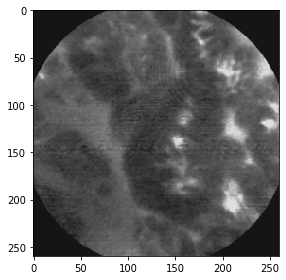

In [16]:
io.imshow(img[500]) 

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores
Lo primero es transformar la lista img en una matriz


In [17]:
IMG = np.stack(img, axis=0)  # Toma una secuencia de matrices y las apila a lo largo 
                            # de un tercer eje para hacer una sola matriz              
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen. 

In [19]:
n_imagenes = len(IMG)
X = IMG.reshape((n_imagenes, -1)) # -1 todo lo que sobre se pasa a otro eje
X.shape # 67600

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

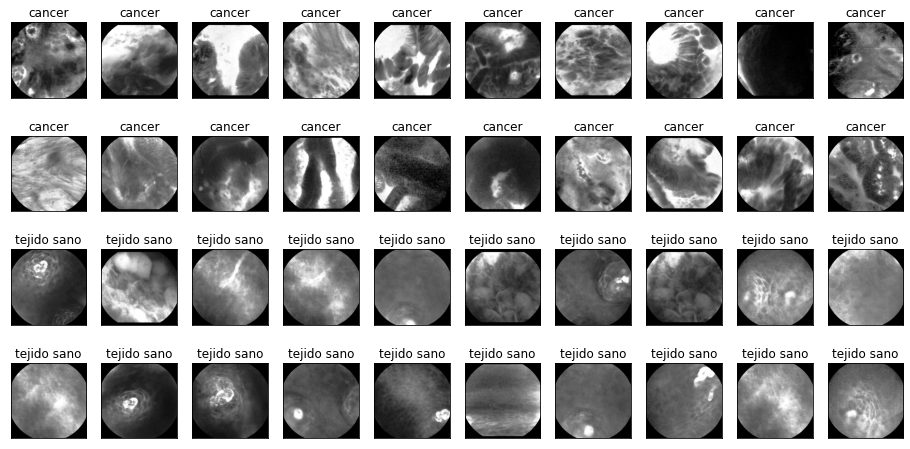

In [18]:
#El método GroupBy de Pandas separa un data frame en varios data frames
porClase = datos.groupby('class_number')

#elije al azar n muestras de cada subconjunto y guarda la posición de las figuras elegidas en una lista
n = 20
c = random.sample(porClase.get_group(1).index.tolist(),n) ## Tejido Cancerigeno
s = random.sample(porClase.get_group(0).index.tolist(),n)

# Grafica 20 imágenes aleatorias de tejido con cáncer y 20 de tejido sano

fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([]) # Sin Ejes
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Entrenamiento utilizando perceptrón simple con conjunto de entrenamiento y prueba

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, # 70% de datos en entrenamiento
                                                    shuffle = True, random_state = 0)

In [21]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("Y: ", y_train.shape)
unique, counts= np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

# AGREGAR PROPORCIONES EN %

print("Test set")
print("X: ", X_test.shape)
print("Y: ", y_test.shape)
unique, counts= np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
Y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
Y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



### 3.2  Entrenamiento



In [26]:
# ESTE MODELO SE HARA LO QUE SIGUE DLE NOTEBOOK

model = Perceptron(max_iter=45,  random_state=0) 
model.fit(X_train,y_train)                                  

print("Iterations: ", model.n_iter_) # ATRIBUTO - CARACT DE MODELO

print("Precisión test: %.2f%%" % (model.score(X_test, y_test)*100.0)) # EN ESTA PARTE SE ADELANTO EL PREDICT PARA SACAR SCORE DIRECTO

Iterations:  44
Precisión test: 90.19%


In [24]:
# PRUEBA CON MENOR ITERACIONES
model = Perceptron(max_iter=20,  random_state=0) 
print("Precisión test: %.2f%%" % (model.score(X_test, y_test)*100.0))ceptron( max_iter = 20,  random_state=0)
# ES EL NUMERO MAXIMO, YA QUE PUEDE CONTINUAR CONTINA
# La ultima ITERACIÓN - CORRESPONDE AL MEJOR MODELO
# CON LAS ITERACIONES VA PROBANDO DONDE DEBE ESTAR EL HIPERPLANO (EL MEJOR) 
model.fit(X_train,y_train)                                  

print("Iterations: ", model.n_iter_)

print("Precisión train: %.2f%%" % (model.score(X_train, y_train)*100.0))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Iterations:  20
Precisión train: 90.52%
Precisión test: 85.65%


In [25]:
model = Perceptron( max_iter = 40,  random_state=0)
# ES EL NUMERO MAXIMO, YA QUE PUEDE CONTINUAR CONTINA
# La ultima ITERACIÓN - CORRESPONDE AL MEJOR MODELO
# CON LAS ITERACIONES VA PROBANDO DONDE DEBE ESTAR EL HIPERPLANO (EL MEJOR) 
model.fit(X_train,y_train)                                  

print("Iterations: ", model.n_iter_)

print("Precisión train: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Precisión test: %.2f%%" % (model.score(X_test, y_test)*100.0))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Iterations:  40
Precisión train: 96.47%
Precisión test: 90.26%


In [27]:
#Guardamos los coeficientes del modelo como beta
beta = model.coef_
print(beta.shape) # los coeficientes que deben multiplicarse LAS PONDERACIONES

(1, 67600)


In [29]:
beta[0, 50310:50320] # Aqui se dirige a un Punto Medio de la Imagen, para conocer las Betas que se aplican en esa Zona

array([ -1.92002706,  26.43550275,  48.33832196,  60.5412651 ,
        36.79920392,  20.46658157,  -2.35208118, -16.18895686,
       -16.80207686,   4.81493412])

In [28]:
model.intercept_ # CREA EL HIPERPLANO, EL INTERCEPTO : LA RECTA QUE DIFERENCIA LAS IMAGENES

array([-42.])

In [30]:
y_predict = model.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo 
# el predict usa el modelo que se compone del INTERCEPT y de la BETA

In [ ]:
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_predict)*100))

Accuracy: 90.19%


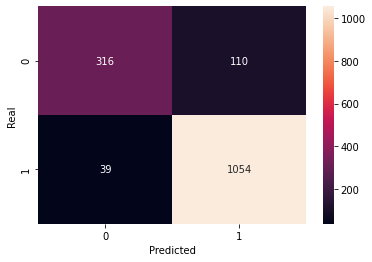

In [31]:
#Matriz de confusión

data = {'Y_Real':  y_test,
        'Y_Prediccion':y_predict
        }

df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

In [32]:
y_test.value_counts()

1    1093
0     426
Name: class_number, dtype: int64

## Paso 4. Entrenamiento de perceptron utilizando el método de validación K-fold Cross Validation 

(4 min aprox)

In [33]:
%%time

# SUSTITO DEL MODELO DE SPLIT TRAIN
# Nuestro Total Lo dividimos en 5 Partes
kfold = KFold(n_splits = 5,random_state=0,  shuffle=True)

# Se crean 5 MODELOS con el n_splits
## alpha - hiperparametros: alpha es la regularización cuando no se usa Penalización (DEFAULT)
## tol - criterio cuando PARA (cuando nuestro modelo ya no esta mejorando) (DEFAULT)
## eta - constante por la cual se multiplica los updates (DEFAULT) 
model_kfold = Perceptron(alpha = 0.0001, fit_intercept=True, max_iter=1000, tol=0.001, eta0=1.0, random_state=0, early_stopping=False)
result_kfold = cross_val_score(model_kfold, X, Y, cv = kfold )# CV separa en 5 conjuntos a X , Y

print("Accuracy: %.2f (+/- %02f)" % (result_kfold.mean(), result_kfold.std()))


Accuracy: 0.89 (+/- 0.037545)
CPU times: user 2min 25s, sys: 9.39 s, total: 2min 34s
Wall time: 2min 33s


In [34]:
result_kfold # La Accuracy de los SPLITS

array([0.83415597, 0.90720632, 0.93089832, 0.9298419 , 0.86857708])

# Ejercicio

1. Variar el número máximo de iteraciones (max_iter) al crear el modelo con Perceptron, utilizando 10, 20, 30, 40, 50, 100, 200 y observar la variación de la precición (accuracy)
2. Entrenar el perceptrón , considerando un conjunto de prueba y otro de entrenamiento,  variando el tamaño del conjunto de datos, usando 25%,  50% , y 75% del total de imágenes (pista: para crear un subconjunto de datos con el 25% de las imágenes usar el filtro mask como se muestra en la siguiente celda).

In [37]:
# PRUEBA CON DISTINTAS ITERACIONES

for i in [ 10, 20, 30, 40, 50, 100, 200 ]:
  
  model_pruebas = Perceptron(max_iter = i,  random_state=0) 
  model_pruebas.fit(X_train,y_train)                                  
  print("Iterations: ", model_pruebas.n_iter_)
  print("Precisión train: %.2f%%" % (model_pruebas.score(X_train, y_train)*100.0))
  print("Precisión test: %.2f%%" % (model_pruebas.score(X_test, y_test)*100.0))

  # INSIGHTS A PARTIR DE LAS 44 ITERACIONES EL MODELO NO MEJORA.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Iterations:  10
Precisión train: 82.36%
Precisión test: 79.13%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Iterations:  20
Precisión train: 90.52%
Precisión test: 85.65%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Iterations:  30
Precisión train: 51.44%
Precisión test: 47.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Iterations:  40
Precisión train: 96.47%
Precisión test: 90.26%
Iterations:  44
Precisión train: 95.49%
Precisión test: 90.19%
Iterations:  44
Precisión train: 95.49%
Precisión test: 90.19%
Iterations:  44
Precisión train: 95.49%
Precisión test: 90.19%


In [ ]:
#Muestra de base de datos con el 25% de los casos
mask = np.random.choice([False, True], len(X), p=[0.75, 0.25])
X25=X[mask]
Y25=Y[mask]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X25, Y25, test_size=0.3, 
                                                    shuffle=True, random_state=0)

In [ ]:
model = Perceptron(max_iter=100,  random_state=0) 
model.fit(X_train,y_train)                                  

print("Iterations: ", model.n_iter_)

print("Precisión test: %.2f%%" % (model.score(X_test, y_test)*100.0))

Iterations:  45
Precisión test: 81.44%


In [ ]:
mask = np.random.choice([False, True], len(X), p=[0.50, 0.50])
X50 = X[mask]
Y50 = Y[mask]

X_train, X_test, y_train, y_test = train_test_split(X50, Y50, test_size=0.3, 
                                                    shuffle=True, random_state=0)


model = Perceptron(max_iter=100,  random_state=0) 
model.fit(X_train,y_train)                                  

print("Iterations: ", model.n_iter_)

print("Precisión test: %.2f%%" % (model.score(X_test, y_test)*100.0))

Iterations:  34
Precisión test: 82.15%
